In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from pmdarima import auto_arima
import mlflow
import sklearn
import mlflow.sklearn
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [47]:
df = pd.read_excel('Tick Sightings.xlsx')

In [48]:
city = 'Manchester'
window_size = 4

df['date'] = pd.to_datetime(df['date'])

df_manchester = df[df['location'] == city].copy()

df_manchester = df_manchester.set_index('date')

weekly_counts = df_manchester['id'].resample('W').count()
smoothed = weekly_counts.rolling(window=window_size, min_periods=1).mean()

print(smoothed.head())

date
2012-01-29    1.000000
2012-02-05    0.500000
2012-02-12    0.666667
2012-02-19    0.500000
2012-02-26    0.250000
Freq: W-SUN, Name: id, dtype: float64


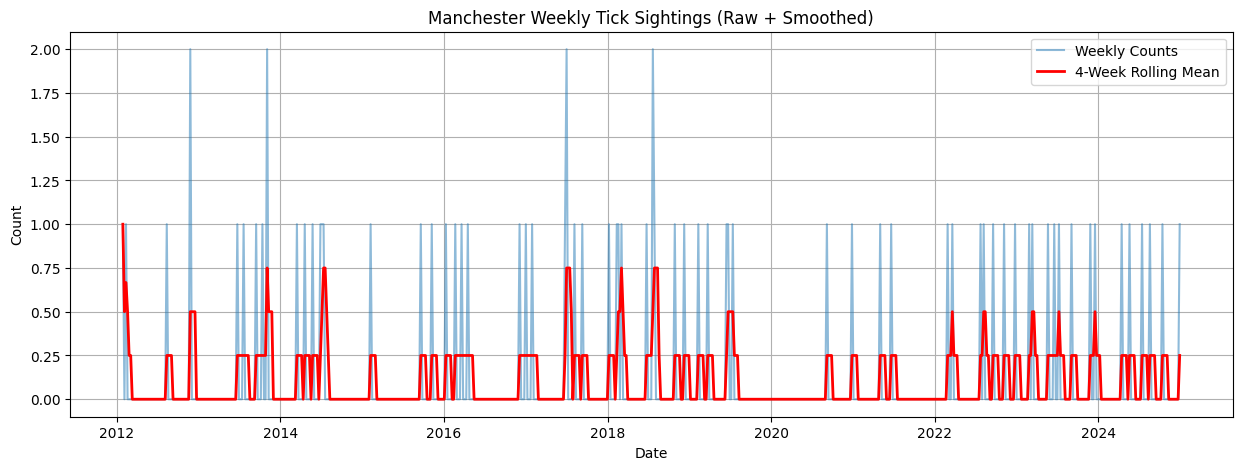

In [49]:
plt.figure(figsize=(15,5))
plt.plot(weekly_counts, label="Weekly Counts", alpha=0.5)
plt.plot(smoothed, label="4-Week Rolling Mean", linewidth=2, color="red")
plt.title("Manchester Weekly Tick Sightings (Raw + Smoothed)")
plt.xlabel("Date")
plt.ylabel("Count")
plt.grid(True)
plt.legend()
plt.show()

In [50]:
mlflow.set_experiment("Tick Forecasting")
with mlflow.start_run():

    # default max_p = 5, max_q = 5, max_d = 2
    model = auto_arima(
        smoothed,
        seasonal=False,
        trace=True,
        error_action="ignore",
        suppress_warnings=True,
        max_p = 1,
        max_q = 2,
        max_d = 1,
        start_p = 0,
        start_q = 0,
        start_d = 0
    )

    
    forecast_7_weeks = model.predict(n_periods=7)
    print("\n")
    print("Next 7 weeks forecast:")
    print(forecast_7_weeks)

    mlflow.log_param("city", city)
    mlflow.log_param("window_size", window_size)
    mlflow.log_param("arima_order", model.order)
    mlflow.log_param("num_weekly_points", len(weekly_counts))

    # Logging train metrics
    fitted_values = model.predict_in_sample()
    
    mae = mean_absolute_error(smoothed, fitted_values)
    mse = mean_squared_error(smoothed, fitted_values)

    mlflow.log_metric("mae", mae)
    mlflow.log_metric("mse", mse)

    # Logging forecast output
    for i, pred in enumerate(forecast_7_weeks):
        mlflow.log_metric(f"forecast_week_{i+1}", pred)

mlflow.end_run()

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-274.011, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-1051.119, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-1051.803, Time=0.02 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-1099.881, Time=0.04 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-853.526, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=-1136.753, Time=0.10 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=-978.167, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=-1079.981, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=-978.313, Time=0.04 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0] intercept
Total fit time: 0.432 seconds


Next 7 weeks forecast:
2025-01-05    0.209943
2025-01-12    0.342460
2025-01-19    0.234918
2025-01-26    0.177312
2025-02-02    0.146455
2025-02-09    0.129927
2025-02-16    0.121073
Freq: W-SUN, dtype: float64


In [51]:
cities = df['location'].unique()

models = {}          # store fitted models
forecasts = {}       # store predictions
weekly_data = {}     # store weekly series per city

for city in cities:
    print("\n============================")
    print(f"Processing city: {city}")
    print("============================")
    
    df_city = df[df['location'] == city].copy()
    df_city = df_city.set_index('date')

    # Create weekly counts
    weekly = df_city['id'].resample('W').count()

    # Optional smoothing
    smoothed = weekly.rolling(window=4, min_periods=1).mean()

    # Fit ARIMA
    model = auto_arima(
        smoothed,
        seasonal=False,
        trace=False,
        error_action="ignore",
        suppress_warnings=True
    )

    # Store model
    models[city] = model
    weekly_data[city] = weekly

    # Forecast next 7 weeks
    preds = model.predict(n_periods=7)
    forecasts[city] = preds

    print(f"Next 7 weeks forecast for {city}:")
    print(preds)


Processing city: Manchester
Next 7 weeks forecast for Manchester:
2025-01-05    0.290422
2025-01-12    0.234213
2025-01-19    0.271690
2025-01-26    0.153128
2025-02-02    0.159595
2025-02-09    0.104858
2025-02-16    0.089040
Freq: W-SUN, dtype: float64

Processing city: London
Next 7 weeks forecast for London:
2024-10-06    0.253564
2024-10-13    0.257082
2024-10-20    0.256230
2024-10-27    0.131659
2024-11-03    0.111569
2024-11-10    0.092895
2024-11-17    0.079766
Freq: W-SUN, dtype: float64

Processing city: Glasgow
Next 7 weeks forecast for Glasgow:
2025-01-12    0.302224
2025-01-19    0.268056
2025-01-26    0.303539
2025-02-02    0.189880
2025-02-09    0.184224
2025-02-16    0.120244
2025-02-23    0.096292
Freq: W-SUN, dtype: float64

Processing city: Birmingham
Next 7 weeks forecast for Birmingham:
2025-01-05    0.220859
2025-01-12    0.305788
2025-01-19    0.250921
2025-01-26    0.142663
2025-02-02    0.112425
2025-02-09    0.123535
2025-02-16    0.105596
Freq: W-SUN, dtype

In [52]:
models['Manchester'].predict(n_periods=7)

2025-01-05    0.290422
2025-01-12    0.234213
2025-01-19    0.271690
2025-01-26    0.153128
2025-02-02    0.159595
2025-02-09    0.104858
2025-02-16    0.089040
Freq: W-SUN, dtype: float64